# Previsão de Renda

In [1]:
# importando as bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Descrição da atividade

Uma instituição financeira quer conhecer melhor o perfil de renda de seus novos clientes para diversos fins, por exemplo, melhor dimensionar o limite de cartões de crédito dos novos clientes, sem necessariamente solicitar olerites ou documentações que impactem na experiência do seu cliente.

Para isto, conduziu um estudo com alguns clientes, comprovando suas rendas através de olerites e outros documentos, e pretende construir um modelo preditivo para esta renda com base em algumas variáveis que já possui em seu banco de dados.

As variáveis são intuitivas - note que há uma variável 'index' que é um identificador do cliente e que em geral o ```read_csv``` do pandas coloca também uma variável sequencial.

Estes dados estão no arquivo ```previsao_de_renda.csv```. Carregue-o em um *dataframe*.

1) Avalie a estrutura de correlação das variáveis quantitativas através de um gráfico de "matriz de dispersão" e através da avaliação gráfica da matriz de correlações. Veja se você identifica algum padrão interessante ou que te faça sentido.

In [2]:
# Checa se há dados faltantes

def missing_values(df) -> None:
    
    
    if True in df.isna().any().to_list():
        print('Valores faltantes nas seguintes colunas: \n')
        missing_perc = 100 * df.isna().mean()
        print(missing_perc)
    else:
        print('Não há valores faltantes.')
    
    return None

# checa se há duplicatas

def duplicated_values(df) -> None:
    
    
    if df.shape[0] == df.drop_duplicates().shape[0]:
        print('Não há duplicatas. \n')
    else:
        num_duplicates = df.duplicated().sum()
        print(f'Número de duplicatas: {num_duplicates}')
        print(f'Porcentagem de dados únicos: {round(100*(1-num_duplicates/df.shape[0]), 2)}% \n')
    
    
    return None

# confere o tipo de dados presentes na base pré-tratamento

def data_type(df) -> None:
    
    print(f'Shape pré-tratamento: {df.shape} \n')
    
    # Seleciona colunas numéricas
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
    print('\nColunas numéricas:')
    print(f'{num_cols}\n')
    
    # Seleciona colunas categóricas
    cat_cols = df.select_dtypes(include=['object', 'category', 'datetime64[ns]']).columns.to_list()
    print('\nColunas categóricas:')
    print(f'{cat_cols} \n')
    
    # Seleciona colunas bool
    bool_cols = df.select_dtypes(include=['bool']).columns.to_list()
    print('\nColunas booleanas:')
    print(f'{bool_cols} \n')
    
    
    return None

# Checa dados preliminares da base de dados

def checking_base(df) -> None:
    
    
    data_type(df)
    
    print('Checagem de duplicatas:')
    duplicated_values(df)
     
    missing_values(df)
    
    return None

### Carregamento e tratamento dos dados

In [3]:
arquivo = 'previsao_de_renda.csv'
df = pd.read_csv(arquivo, na_values=('na', 'NaN', 'nan'))

# remove a colunas: a primeira coluna, e a coluna sexo do arquivo csv
df = df.iloc[: , 1:].drop(columns=['sexo'], axis=1)

In [4]:
df.head()

,data_ref,index,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,mau,renda
0,2015-01-01,8682,False,True,1,Assalariado,Secundário,Casado,Casa,36,3.575342,3.0,False,3369.24
1,2015-01-01,12830,True,True,0,Empresário,Secundário,Casado,Casa,42,0.860274,2.0,False,6096.14
2,2015-01-01,2885,True,True,2,Assalariado,Superior completo,Casado,Casa,31,8.065753,4.0,False,5658.98
3,2015-01-01,16168,True,False,0,Empresário,Secundário,Casado,Casa,50,1.208219,2.0,False,7246.69
4,2015-01-01,12438,False,False,0,Assalariado,Secundário,Casado,Casa,52,13.873973,2.0,False,4017.37


Se faz necessário criar colunas com o ano e o mês que o cliente pediu a análise de crédito.

In [5]:
# converte a coluna data_ref para o tipo datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])
# cria a coluna ano e mês
df['ano'] = df['data_ref'].dt.year
df['mes'] = df['data_ref'].dt.month

 **Será apenas avaliado o ano de 2015, por completeza**

In [6]:
df_2015 = df[df['ano'] == 2015]

In [7]:
# analisa previamente a base usando a função definida acima
checking_base(df_2015)

Shape pré-tratamento: (12000, 16) 


Colunas numéricas:
['index', 'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'ano', 'mes']


Colunas categóricas:
['data_ref', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'] 


Colunas booleanas:
['posse_de_veiculo', 'posse_de_imovel', 'mau'] 

Checagem de duplicatas:
Número de duplicatas: 387
Porcentagem de dados únicos: 96.78% 

Valores faltantes nas seguintes colunas: 

data_ref                  0.000000
index                     0.000000
posse_de_veiculo          0.000000
posse_de_imovel           0.000000
qtd_filhos                0.000000
tipo_renda                0.000000
educacao                  0.000000
estado_civil              0.000000
tipo_residencia           0.000000
idade                     0.000000
tempo_emprego            17.058333
qt_pessoas_residencia     0.000000
mau                       0.000000
renda                     0.000000
ano                       0.000000
mes                   

Pela análise acima, as seguintes medidas serão tomadas:

* Remoção dos dados duplicados 
* Os valores ausentes serão removidos, pois são ~17% da base de dados. E como se refere ao tempo de trabalho, fica complicado fazer estimativas.

In [8]:
# dropando os duplicados e removendo os valores missing

df_2015 = df_2015.drop_duplicates()
df_2015 = df_2015.dropna()

Checando a base novamente.

In [9]:
checking_base(df_2015)

Shape pré-tratamento: (9628, 16) 


Colunas numéricas:
['index', 'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'ano', 'mes']


Colunas categóricas:
['data_ref', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'] 


Colunas booleanas:
['posse_de_veiculo', 'posse_de_imovel', 'mau'] 

Checagem de duplicatas:
Não há duplicatas. 

Não há valores faltantes.


Se faz a necessidade de criar colunas dummies para as variáveis que são do tipo bool. Também será retirado as colunas ano e mês para não entrar na análise de correlação. Por fim, será removido a coluna index, já que o número do cliente não nos interessa agora.

In [31]:
df_dummies_2015 = pd.get_dummies(df_2015, 
                            columns=['posse_de_veiculo', 'posse_de_imovel', 'mau'],
                            prefix=('veiculo', 'imovel', 'default'),
                            drop_first=True).drop(columns=['index','ano', 'mes'])
df_dummies_2015.head()

,data_ref,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,veiculo_True,imovel_True,default_True
0,2015-01-01,1,Assalariado,Secundário,Casado,Casa,36,3.575342,3.0,3369.24,0,1,0
1,2015-01-01,0,Empresário,Secundário,Casado,Casa,42,0.860274,2.0,6096.14,1,1,0
2,2015-01-01,2,Assalariado,Superior completo,Casado,Casa,31,8.065753,4.0,5658.98,1,1,0
3,2015-01-01,0,Empresário,Secundário,Casado,Casa,50,1.208219,2.0,7246.69,1,0,0
4,2015-01-01,0,Assalariado,Secundário,Casado,Casa,52,13.873973,2.0,4017.37,0,0,0


In [40]:
df_dummies_2015['idade'].min()

22

<AxesSubplot:>

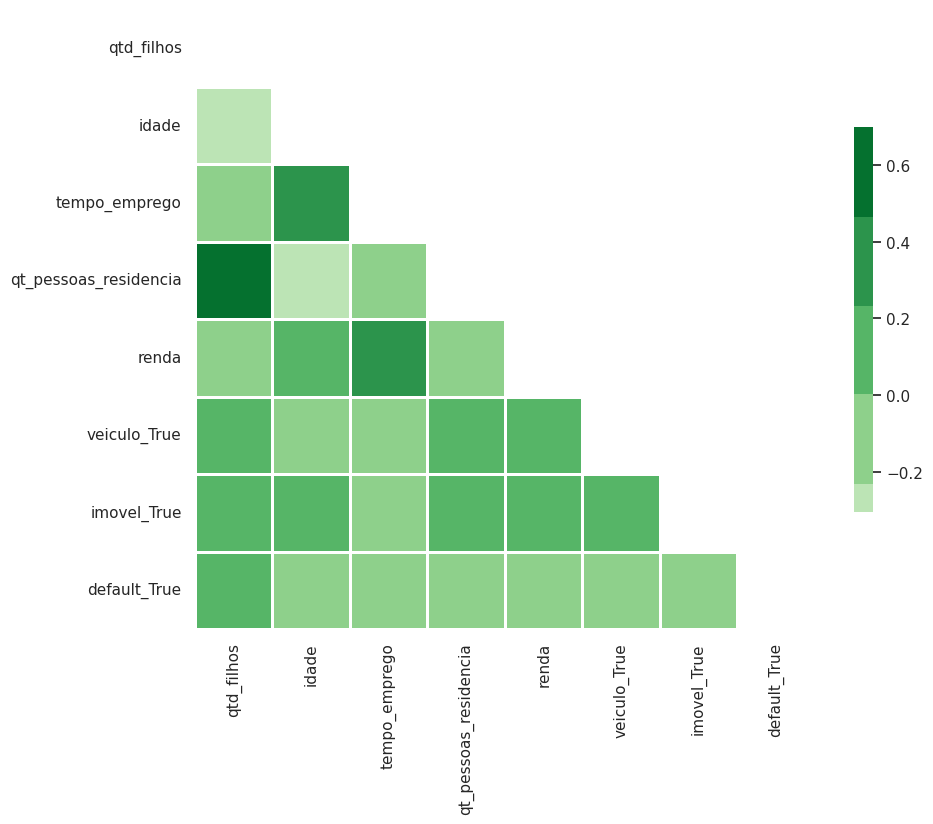

In [36]:
# analisando a matrix de correlação através de um heatmap

# construindo um heatmap para melhor analisar a matriz de correlação:

sns.set_theme(style="white")
corr = df_dummies_2015.corr(numeric_only=True)
mask = np.triu(df_dummies_2015.corr(numeric_only=True))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette("Greens")

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap,
            vmax=.7, 
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .5}
           )

In [37]:
# para ter uma visão númerica dos dados acima:
corr = df_dummies_2015.corr(numeric_only=True)
corr['renda'].sort_values(ascending=False).to_frame()

,renda
renda,1.000000
tempo_emprego,0.391229
idade,0.145263
imovel_True,0.039326
veiculo_True,0.038574
qt_pessoas_residencia,-0.001671
qtd_filhos,-0.015998
default_True,-0.020686


A variável renda apresenta um nível de correlação alto com as outras seguintes:
* Tempo de Emprego
* Idade
* Posse de Imóvel
* Posse de Veículo

2) Avalie um gráfico de dispersão (*scatterplot*) específico para as duas variáveis mais correlacionadas com *renda*.

Aqui, será analisadas a relação de 'Tempo de Emprego' e 'Idade' com a variável renda.

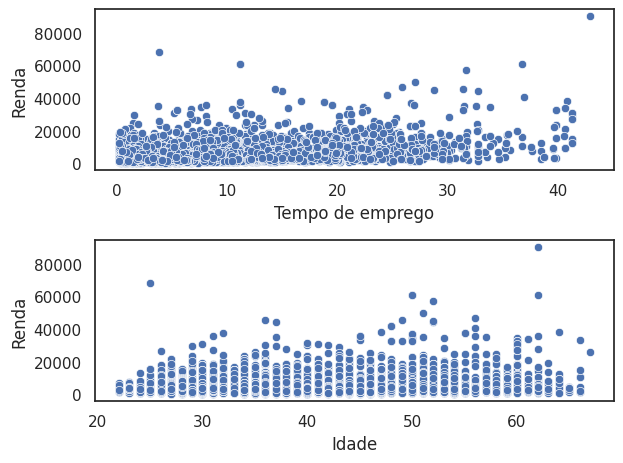

In [57]:
fig, axs = plt.subplots(nrows=2)

variaveis = ['tempo_emprego', 'idade']

for i, var in enumerate(variaveis):
    sns.scatterplot(data=df_dummies_2015, x=var, y='renda', ax=axs[i])
    axs[i].set_ylabel('Renda')
axs[0].set_xlabel('Tempo de emprego')
axs[1].set_xlabel('Idade')

plt.tight_layout()

#### Baseado nos gráficos acima, e utilizando a posse de veículos como variável correlacionada com renda, é possível observar que:

i) A distribuição de renda é maior para algumas pessoas de maior idade. 

ii) Ter mais tempo de emprego pode vir a indicar um aumento da renda.

3) Na sua aopinião, há outliers na variável renda?

Text(0.5, 1.0, 'Boxplot')

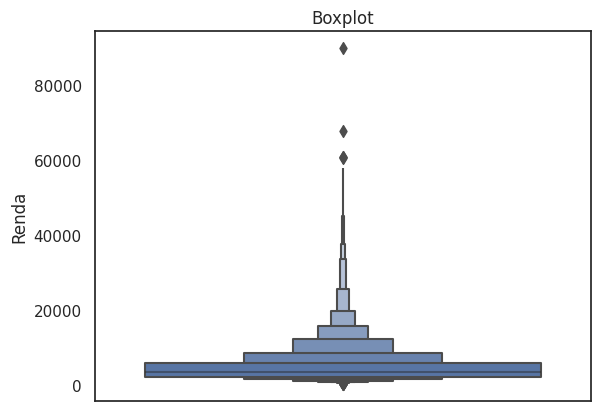

In [43]:
sns.boxenplot(data=df_2015, y='renda')
plt.ylabel('Renda')
plt.title('Boxplot')

De acordo com o boxplot, sim, há outliers de renda. Contudo, pela natureza da variável, não podemos desconsiderar nenhum valor. Pode ocorrer do cliente apenas ter uma renda alta. Isto é observado em conjunto com os outros parâmetros.

4) Calcule o logaritmo da variável renda e repita a sequência de análise

<AxesSubplot:>

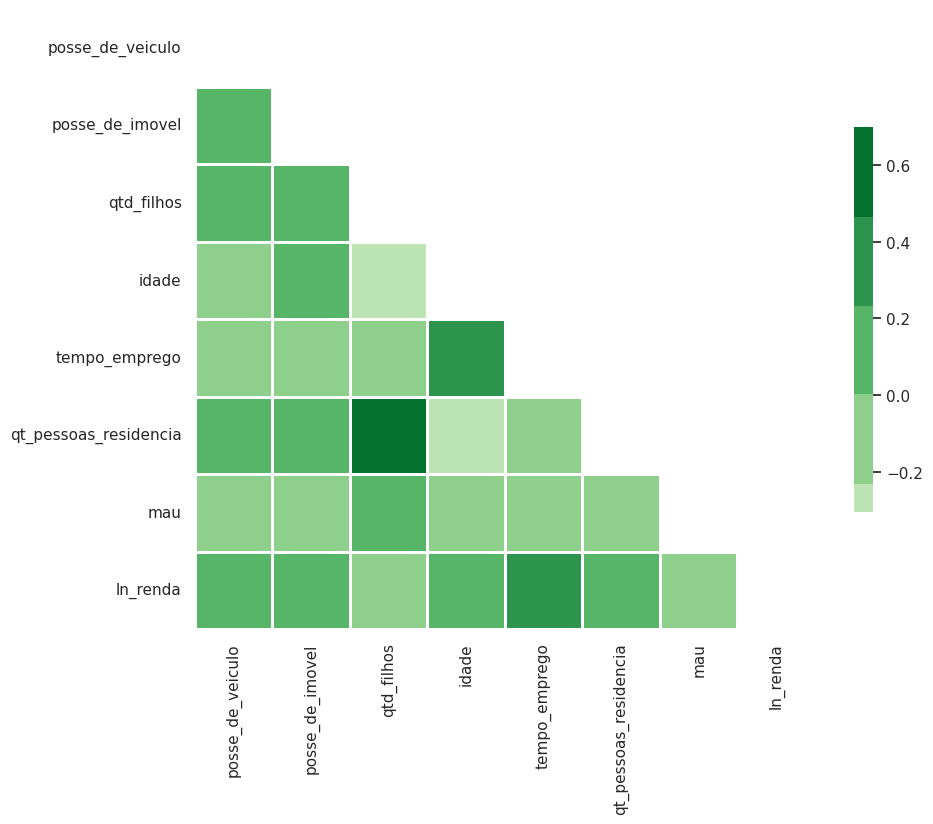

In [55]:
# analisando a matrix de correlação para o ln através de um heatmap

dummies_df_ln = df_2015.copy().drop(columns=['index', 'ano', 'mes'])
dummies_df_ln['ln_renda'] = np.log(dummies_df_ln['renda'])
dummies_df_ln = dummies_df_ln.drop(columns=['renda'])

sns.set_theme(style="white")
corr = dummies_df_ln.corr(numeric_only=True)
mask = np.triu(dummies_df_ln.corr(numeric_only=True))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette("Greens")

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap,
            vmax=.7, 
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .5}
           )

In [56]:
# para ter uma visão númerica dos dados acima:
corr = dummies_df_ln.corr(numeric_only=True)
corr['ln_renda'].sort_values(ascending=False).to_frame()

,ln_renda
ln_renda,1.000000
tempo_emprego,0.378967
idade,0.141094
posse_de_veiculo,0.069601
posse_de_imovel,0.055154
qt_pessoas_residencia,0.008711
qtd_filhos,-0.008219
mau,-0.024891


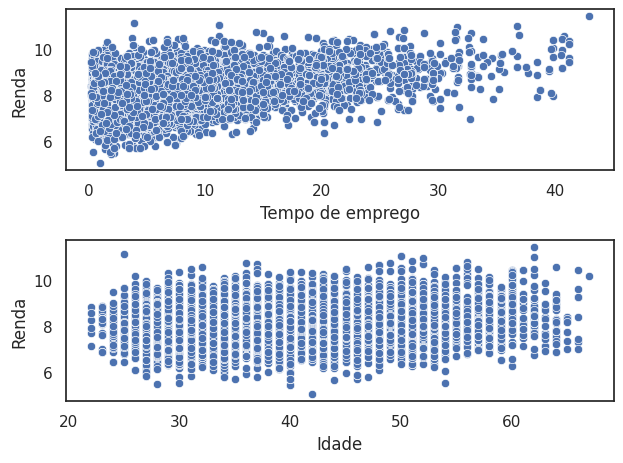

In [59]:
fig, axs = plt.subplots(nrows=2)

variaveis = ['tempo_emprego', 'idade']

for i, var in enumerate(variaveis):
    sns.scatterplot(data=dummies_df_ln, x=var, y='ln_renda', ax=axs[i])
    axs[i].set_ylabel('Renda')
axs[0].set_xlabel('Tempo de emprego')
axs[1].set_xlabel('Idade')

plt.tight_layout()

5) A aplicação do LOG você acha que melhorou ou piorou a análise?

Em relação a visuzalição do tempo de emprego, a observação de que a renda é maior conforme o tempo de emprego aumenta fica mais clara. Já em função da idade, talvez não tenha ajudado tanto.

6) Com o que você viu em aula, faça uma análise das variáveis qualitativas (posse de imóvel e posse de veículo) para verificar se são boas preditoras de *renda*. Alguma delas parece discriminar *renda* de forma estatisticamente significante?

In [72]:
df_qualitativas = df_dummies_2015[['renda', 'imovel_True', 'veiculo_True','default_True']]

df_qualitativas.head()

,renda,imovel_True,veiculo_True,default_True
0,3369.24,1,0,0
1,6096.14,1,1,0
2,5658.98,1,1,0
3,7246.69,0,1,0
4,4017.37,0,0,0


In [73]:
# checando a base de qualitativas
checking_base(df_qualitativas)

Shape pré-tratamento: (9628, 4) 


Colunas numéricas:
['renda']


Colunas categóricas:
[] 


Colunas booleanas:
[] 

Checagem de duplicatas:
Número de duplicatas: 2564
Porcentagem de dados únicos: 73.37% 

Não há valores faltantes.


In [76]:
# dropando as duplicatas

df_qualitativas.drop_duplicates(inplace=True)

/tmp/ipykernel_4704/1516720172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_qualitativas.drop_duplicates(inplace=True)


<AxesSubplot:>

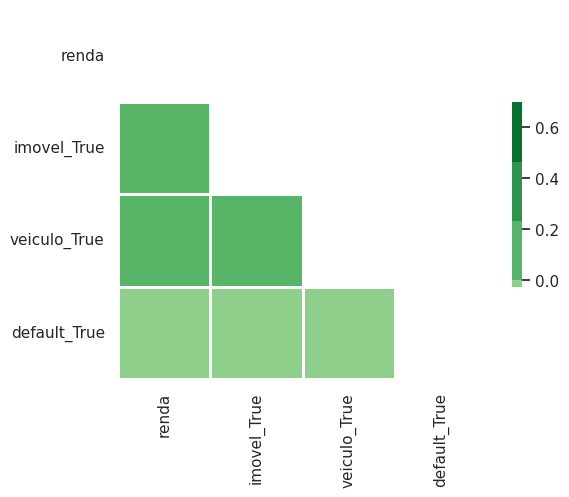

In [83]:
sns.set_theme(style="white")
corr = df_qualitativas.corr(numeric_only=True)
mask = np.triu(df_qualitativas.corr(numeric_only=True))
#f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette("Greens")

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap,
            vmax=.7, 
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .5}
           )

In [81]:
# calculando a matriz de correlação

corr = df_qualitativas.corr(numeric_only=True)
corr['renda'].sort_values(ascending=False).to_frame()

,renda
renda,1.000000
veiculo_True,0.036723
imovel_True,0.032780
default_True,-0.014801


In [84]:
# cria dataframes que indicam se o cliente possui veículo/imóvel e é default

df_possui_veic = df_qualitativas[df_qualitativas['veiculo_True']==1]
df_possui_imovel = df_qualitativas[df_qualitativas['imovel_True']==1]
df_possui_veic_default = df_possui_veic[df_possui_veic['default_True'] == 1]
df_possui_imovel_default = df_possui_imovel[df_possui_imovel['default_True'] == 1]

# calcula a porcentagem de pessoas que são default e possuem imóvel e/ou veiculo

veiculo_porcen = (df_possui_veic_default.shape[0]/df_possui_veic.shape[0])*100
imovel_porcen = (df_possui_imovel_default.shape[0]/df_possui_imovel.shape[0])*100

print(f'Possuem véiculo e são default: {round(veiculo_porcen,2)}%')
print(f'Possuem imóvel e são default: {round(imovel_porcen,2)}%')

Possuem véiculo e são default: 2.16%
Possuem imóvel e são default: 2.07%


In [89]:
df_quali_ambos_default = df_qualitativas[(df_qualitativas['default_True'] == 1) 
   & (df_qualitativas['imovel_True'] == 1) 
   & (df_qualitativas['veiculo_True'] == 1)]

ambos_default_porc = (df_quali_ambos.shape[0]/df_qualitativas.shape[0])*100
print(f'Possuem imóvel e véiculo e são default: {round(ambos_default_porc,2)} %')

Possuem imóvel e véiculo e são default: 0.48 %


<AxesSubplot:xlabel='renda'>

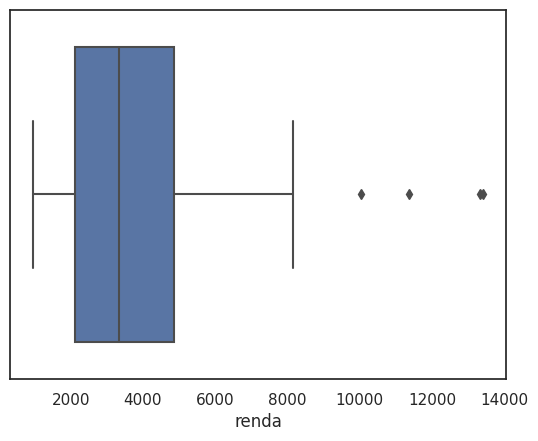

In [93]:
# observa a distribuição de renda para os clientes que são default, possuem veículo e imóvel

sns.boxplot(data=df_quali_ambos, x='renda', hue='default_True')

### Considerando os dados acima:

* Para prever se um cliente será default ou não, é seguro dizer que ter imóvel e/ou veículo é um indicativo de um bom cliente.

### **Voltando a trabalhar com o dataframe que contém datas.**

7) Construa um gráfico de barras para avaliar a distribuição das variáveis qualitativas no tempo. Você acha que houve alguma alteração importante a ser investigada?

In [103]:
# agrupando index do cliente e tirando a média dos parâmetros

df_2 = df_2015[['index','posse_de_veiculo','posse_de_imovel','mes', 'mau']].groupby(by='index').mean()

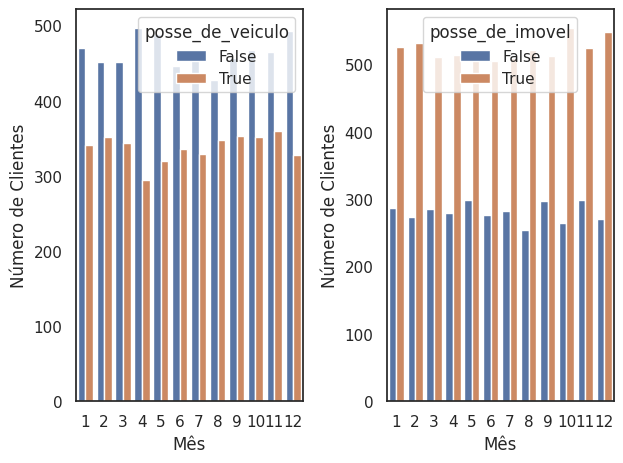

In [101]:
var_qualitativas = ['posse_de_veiculo', 'posse_de_imovel']
index = list(range(0,2))

fig,axs = plt.subplots(ncols=2)

for var,i in zip(var_qualitativas,index):
    
    sns.countplot(data=df_2, 
                x='mes',
                hue=var,
                ax=axs[i])

    axs[i].set_xlabel('Mês')
    axs[i].set_ylabel('Número de Clientes')
    
plt.tight_layout()

#### Vemos que as variáveis qualitativas se mantém estável durante todo o ano de 2015. Se tornando confiáveis para análise.

8) Para cada variável qualitativa, construa um gráfico mostrando as médias de cada nível da variável no tempo e avalie a estabilidade. Houve alguma alteração importante? Você acha que se pode utilizar essas variáveis em uma modelagem?

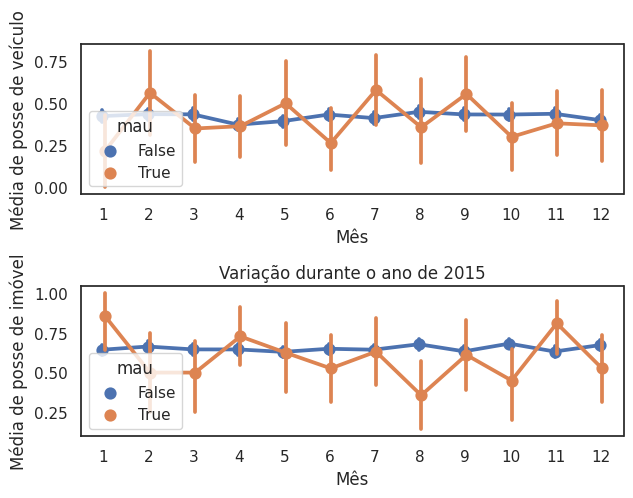

In [96]:
var_qualitativas = ['posse_de_veiculo', 'posse_de_imovel']
index = list(range(0,2))

fig,axs = plt.subplots(nrows=2)
sns.pointplot(x='mes', y='posse_de_veiculo',
              hue='mau',
              data=df_2, 
              dodge=True,
              errorbar = ('ci',95), 
              ax=axs[0])
    
sns.pointplot(x='mes', 
              y='posse_de_imovel', 
              hue='mau',
              data=df_2, 
              dodge=True, 
              errorbar = ('ci',95),
              ax=axs[1])

axs[0].set_xlabel('Mês')
axs[1].set_xlabel('Mês')

axs[0].set_ylabel('Média de posse de veículo')
axs[1].set_ylabel('Média de posse de imóvel')

plt.title('Variação durante o ano de 2015')
plt.tight_layout()


### Ao ser considerado que a média para um cliente não-default se mantém estável, e ainda, sabendo que apenas 2% dos clientes são default, as variáveis qualitativas acima são estavéis e podem ser utilizadas para modelagem.